In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")


/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

runThis = False
if(runThis): #run this once to get the data
    data = pd.read_csv('afp_data_sample_1995_onward_v2.csv')

    """
    Format date columns
    """
    data['date'] = pd.to_datetime(data['tradedate'], format='%Y%m%d', errors='ignore')
    data['week'] = (data['date'] - datetime.datetime(1900, 1, 1)).dt.days // 7 + 1

    data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()
    data['pricepctchgd'] = data['pricepctchgd'] / 100  # convert percentage returns to decimal returns

    data['cumret'] = 0
    data['cumalpha'] = 0
    for i in range(0, 20):  # 0-19: 20 trading days ~ 4 weeks
        print(i, end=", ")  # to keep track of slow loop
        # FIRST, CHECK IF LAG WEEK == WEEK
        data['r_shifted'] = data[['osid', 'pricepctchgd']].groupby(['osid'])['pricepctchgd'].shift(i)  # group by OSID
        data['alpha_shifted'] = data[['osid', 'alpha']].groupby(['osid'])['alpha'].shift(i)  # group by OSID

        data['cumret'] = (1 + data['cumret']) * (1 + data['r_shifted']) - 1
        data['cumalpha'] = (1 + data['cumalpha']) * (1 + data['alpha_shifted']) - 1

        if i in [5 - 1, 10 - 1, 15 - 1, 20 - 1]:
            data['ret' + str(i + 1) + 'd'] = data['cumret']
            data['cum_alpha' + str(i + 1) + 'd'] = data['cumalpha']

    data.drop(['cumret', 'r_shifted', 'cumalpha', 'alpha_shifted'], axis=1, inplace=True)

    data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

    xx = list((data['date'].diff(1)).dt.days > 20)
    yy = list((data['osid'].diff(1)) == 0)
    zz = [(a and b) for a, b in zip(xx, yy)]

    problem_rows = list(np.where(zz)[0])

    problem_rows2 = [i - 1 for i in problem_rows]

    problem_rows3 = np.sort(problem_rows + problem_rows2)

    data['index'] = list(data.index)
    for i in problem_rows:
        for j in range(4):  # 0,1,2,3
            if ((data['osid'].diff(1))[i + j] == 0):  # make sure we are still in one unique OSID
                data.loc[i + j, 'ret5d'] = np.nan
                data.loc[i + j, 'cum_alpha5d'] = np.nan

        for j in range(9):  # 0,1,2,3,...,8
            if ((data['osid'].diff(1))[i + j] == 0):  # make sure we are still in one unique OSID
                data.loc[i + j, 'ret10d'] = np.nan
                data.loc[i + j, 'cum_alpha10d'] = np.nan

        for j in range(14):  # 0,1,2,3,...,13
            if ((data['osid'].diff(1))[i + j] == 0):  # make sure we are still in one unique OSID
                data.loc[i + j, 'ret15d'] = np.nan
                data.loc[i + j, 'cum_alpha15d'] = np.nan

        for j in range(19):  # 0,1,2,3,...,19
            if ((data['osid'].diff(1))[i + j] == 0):  # make sure we are still in one unique OSID
                data.loc[i + j, 'ret20d'] = np.nan
                data.loc[i + j, 'cum_alpha20d'] = np.nan


    """
    Shrink dataset
    """
    data_smaller = data.copy()
    data_smaller = data_smaller[data_smaller['inuniverse'] == True].reset_index(drop=True)
    data_smaller = data_smaller.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

    """
    Save data to pickle file
    """
    data_smaller.to_pickle("./afp_data_formatted.pkl")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [ ]:
pip install plotly

In [32]:
import pandas as pd
import numpy as np
import datetime
import scipy.stats
import statsmodels.api as sm
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from statsmodels.tsa.ar_model import AutoReg
from datetime import timedelta
from plotly.subplots import make_subplots

data_raw = pd.read_pickle("data_with_rets.pkl")
#NOTE: using 'data_with_rets' instead of 'afp_data_formatted'
data_raw = data_raw[data_raw['inuniverse'] == True].reset_index(drop=True)


# TODO: Debug
# filter_colnames = ["tradedate", "osid", "symbol", "sector_group", "previoustradedate",
#                    "alpha", "pricehigh", "pricelow", "priceclose", "splitfactor",
#                    "cumsplitfactor", "volume", "pricepctchgd", "alpha", "captl"]

filter_colnames = ["tradedate", "osid", "symbol", "sector_group", "previoustradedate",
                   "alpha", "priceclose", "pricepctchgd", "captl",'avgvol50d', 'coname', 'volume','sp100f', 'nasdaq100f', 'sp500f','ret1d_lag','alpha1d_lag']

# TODO: Debug
# colnames = data_raw.columns
# for element in colnames:
#     print(element)

data = data_raw.filter(filter_colnames)  # Subset data & del raw from environ. to speed up computation
del data_raw

"""
Pre-processing filtered data
"""
data["tradedate"] = pd.to_datetime(data["tradedate"], format="%Y%m%d")
data["sector_group"] = data["sector_group"].fillna(-1)  # Replace NaN sectors with '-1'
data.rename(columns={"captl": "shrout"}, inplace=True)  # Note that shares outstanding are reported in millions
data = data.dropna(subset=["shrout"])

"""
Finding value-weighted returns
"""
# (!) Determining market cap of each sector
data["mktcap"] = (data["shrout"]) * data["priceclose"]
sector_mktcaps = data.groupby(["tradedate", "sector_group"])["mktcap"].sum().reset_index()
data = data.merge(sector_mktcaps, how="left", on=["tradedate", "sector_group"],
                  suffixes=("", "_sector"))  # Note marketcap is reported in millions as well.
agg_mktcap = data.groupby(["tradedate"])["mktcap"].sum().reset_index()
data = data.merge(agg_mktcap, how="left", on=["tradedate"],
                  suffixes=("", "_tot"))
del agg_mktcap
del sector_mktcaps

# (!) Finding change in days & removing irregular occurrences
data = data.sort_values(["osid", "tradedate"]).reset_index(drop=True)
data["change_in_days"] = data.groupby(["osid"])["tradedate"].shift(-1) - data["tradedate"]
data["linear_pricepctchgd"] = data["pricepctchgd"] / data["change_in_days"].dt.days  # interpolated daily % chg
data = data[data["change_in_days"] <= datetime.timedelta(days=10)]  # Delete times where last tradedate > 10 days

# (!) Finding the value-weighted return of each sector
# TODO: Note that we're using the interpolated 1d change in price, NOT the actual change in price.
data["vwret"] = data["linear_pricepctchgd"] * (data["mktcap"] / data["mktcap_sector"]).copy()
vwret_by_sector = data.groupby(["tradedate", "sector_group"])["vwret"].sum().reset_index()
data = data.merge(vwret_by_sector, how="left", on=["tradedate", "sector_group"],
                  suffixes=("", "_sector"))
del vwret_by_sector

# (!) Finding the value-weighted return of the market (universe)
data["vwret"] = data["linear_pricepctchgd"] * (data["mktcap"] / data["mktcap_sector"])
vwret_market = data.groupby(["tradedate"])["vwret"].sum().reset_index()
data = data.merge(vwret_market, how="inner", on=["tradedate"],
                  suffixes=("", "_market"))
del vwret_market

"""
Compute market risk premium & sector risk premium
"""
# (!) Importing LIBOR-USD from FRED: https://fred.stlouisfed.org/series/USDONTD156N
FRED_data = pd.read_csv("FRED_LIBOR.csv")
FRED_data.rename(columns={"USDONTD156N": "LIBOR"}, inplace=True)
FRED_data["DATE"] = pd.to_datetime(FRED_data["DATE"], format="%Y-%m-%d")
# TODO: We convert LIBOR from % to decimal & approximate a daily value (it is annualized) assuming 250 trading days.
FRED_data["LIBOR"] = FRED_data["LIBOR"].astype(str).replace(".", np.nan).astype(float) / 100 / 250
FRED_data["LIBOR"] = (FRED_data["LIBOR"].ffill() + FRED_data["LIBOR"].bfill()) / 2  # Linear interp. missing values

data = data.merge(FRED_data, how="right", left_on=["tradedate"], right_on=["DATE"]).dropna(subset=["osid"])
data = data.drop(columns="DATE")
del FRED_data

# (!) Calculating risk premia
data["mkt_premium"] = data["vwret_market"] - data["LIBOR"]
data["sector_premium"] = data["vwret_sector"] - data["LIBOR"]  # Sector risk premia

"""
Find sensitivity of each stock w.r.t the market & its sector
"""
# (!) Can also get rolling correl using ".rolling(nper).corr()"; This lets us control for time varying Betas.
Beta_market = pd.DataFrame()
Beta_sector = pd.DataFrame()

market_correl = data.groupby(["osid"])[["vwret_market", "linear_pricepctchgd"]].corr().unstack().iloc[:,
                1].reset_index()
sector_correl = data.groupby(["osid"])[["vwret_sector", "linear_pricepctchgd"]].corr().unstack().iloc[:,
                1].reset_index()

Beta_market["osid"] = market_correl["osid"]
Beta_market["rho"] = market_correl.iloc[:, 1]
Beta_sector["osid"] = sector_correl["osid"]
Beta_sector["rho"] = sector_correl.iloc[:, 1]

# (!) Merge betas into main DataFrame
data = data.merge(Beta_market, how="left", on="osid",
                  suffixes=("", "_market"))
data.rename(columns={"rho": "beta_mkt"}, inplace=True)
data = data.merge(Beta_sector, how="left", on="osid",
                  suffixes=("", "_sector"))
data.rename(columns={"rho": "beta_sector"}, inplace=True)
del Beta_market, Beta_sector, market_correl, sector_correl

"""
Finding the 2-factor CAPM-implied model return
"""
data["capm_2f"] = data["LIBOR"] + \
                  data["beta_mkt"] * data["mkt_premium"] + \
                  data["beta_sector"] * data["sector_premium"]
data["epsilon"] = data["linear_pricepctchgd"] - data["capm_2f"]  # equiv. of a 2-factor "alpha"
data["diff"] = data["epsilon"] - data["alpha"]

"""
Create Buy/Sell signals based on our model
"""


def return_10d(df):
    df["model_10d"] = (1 + df["capm_2f"]).rolling(10).apply(np.prod, raw=True) - 1
    df["real_10d"] = (1 + df["linear_pricepctchgd"]).rolling(10).apply(np.prod, raw=True) - 1
    return df


data.sort_values(["osid", "tradedate"], inplace=True)
data = data.groupby("osid").apply(lambda x: return_10d(x))

# (!) See notes for economic intuition of this trading strategy
data["buy_tomorrow"] = 0
data["sell_tomorrow"] = 0

alpha = 1.5
data.loc[data["real_10d"]*alpha > data["model_10d"], "buy_tomorrow"] = 1
data.loc[data["real_10d"]*alpha < data["model_10d"], "sell_tomorrow"] = 1

data["date"] = data["tradedate"]
data

,tradedate,osid,symbol,sector_group,previoustradedate,alpha,priceclose,pricepctchgd,shrout,avgvol50d,...,beta_mkt,beta_sector,capm_2f,epsilon,diff,model_10d,real_10d,buy_tomorrow,sell_tomorrow,date
0,2010-05-19,10048.0,ADI,4.0,20100518.0,0.047326,28.77,0.04239,297690.0,4612396.967,...,0.547833,0.677321,-0.020417,0.062807,0.015481,NaN,NaN,0,0,2010-05-19
165,2010-05-20,10048.0,ADI,4.0,20100519.0,0.020472,28.12,-0.02259,297690.0,4691188.967,...,0.547833,0.677321,-0.096253,0.073663,0.053191,NaN,NaN,0,0,2010-05-20
330,2010-05-21,10048.0,ADI,4.0,20100520.0,0.002053,28.64,0.01849,297981.0,4739906.967,...,0.547833,0.677321,0.014752,-0.008589,-0.010642,NaN,NaN,0,0,2010-05-21
497,2010-05-24,10048.0,ADI,4.0,20100521.0,0.008169,28.47,-0.00594,297981.0,4811200.967,...,0.547833,0.677321,0.001355,-0.007295,-0.015465,NaN,NaN,0,0,2010-05-24
664,2010-05-25,10048.0,ADI,4.0,20100524.0,0.006615,28.67,0.00702,297981.0,4882950.967,...,0.547833,0.677321,0.012381,-0.005361,-0.011976,NaN,NaN,0,0,2010-05-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339345,2021-08-31,78691.0,VSCO,7.0,20210830.0,-0.007836,66.30,-0.00926,91582.0,3884057.143,...,0.024753,0.126494,0.000076,-0.009336,-0.001500,0.006035,-0.063405,0,1,2021-08-31
339550,2021-09-01,78691.0,VSCO,7.0,20210831.0,0.021886,67.79,0.02247,91582.0,3787086.364,...,0.024753,0.126494,0.000841,0.021629,-0.000257,0.006153,-0.040624,0,1,2021-09-01
335050,2021-08-02,78695.0,RSKD,4.0,20210730.0,0.033173,28.32,0.03282,0.0,1881800.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2021-08-02
335051,2021-08-02,78696.0,COOK,7.0,20210730.0,0.091065,24.20,0.08960,0.0,2361550.000,...,1.000000,1.000000,0.017381,0.027419,-0.063647,NaN,NaN,0,0,2021-08-02


In [33]:
print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  253405
Total number of Sells:  313471
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [34]:
data = cp.trade_on_valid_lags_only(data)


There are  582  problems for buying

There are  768  problems for selling
Total number of Buys:  253131
Total number of Sells:  313046


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [35]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  1223  problems for buying

There are  1289  problems for selling
Total number of Buys:  525054
Total number of Sells:  546936

There are  1152  problems for buying

There are  1249  problems for selling
Total number of Buys:  497406
Total number of Sells:  529963

There are  1049  problems for buying

There are  1169  problems for selling
Total number of Buys:  447182
Total number of Sells:  492016

There are  836  problems for buying

There are  1011  problems for selling
Total number of Buys:  365843
Total number of Sells:  421286

There are  582  problems for buying

There are  766  problems for selling
Total number of Buys:  252549
Total number of Sells:  312280


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8.042
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           1.20e-08
Time:                        12:17:57   Log-Likelihood:                 10228.
No. Observations:                3760   AIC:                        -2.044e+04
Df Residuals:                    3753   BIC: 

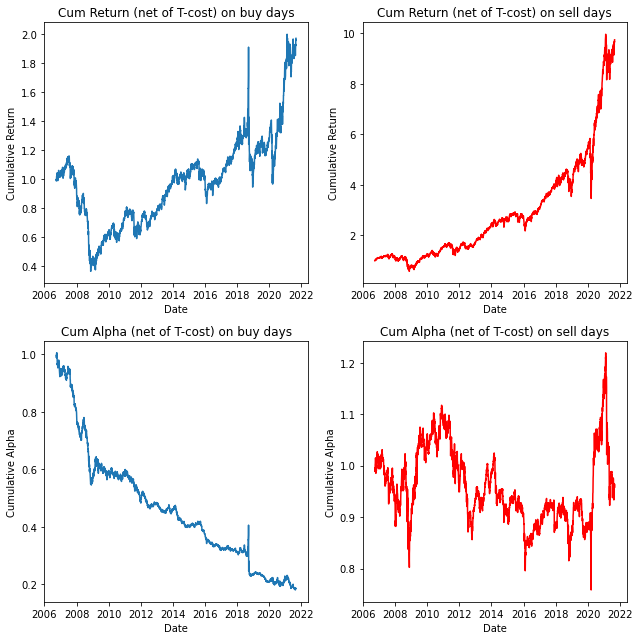

In [36]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     8.533
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           3.14e-09
Time:                        12:18:22   Log-Likelihood:                 10448.
No. Observations:                3760   AIC:                        -2.088e+04
Df Residuals:                    3753   BIC: 

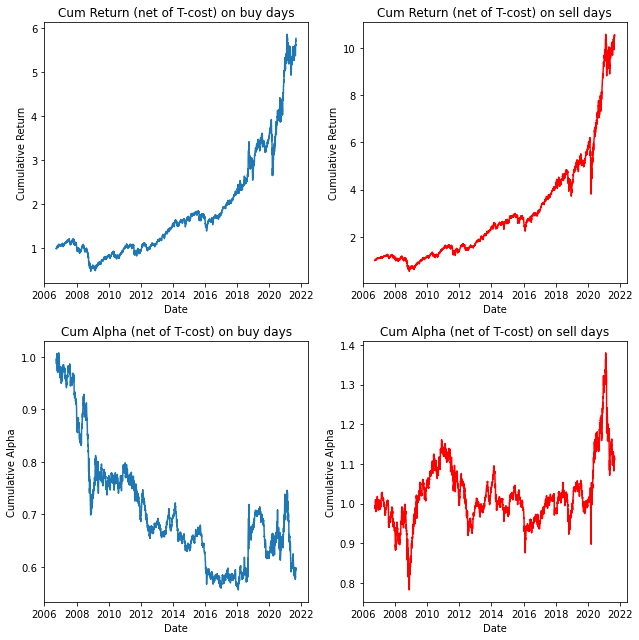

In [37]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.951
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           9.96e-10
Time:                        12:18:46   Log-Likelihood:                 10484.
No. Observations:                3760   AIC:                        -2.095e+04
Df Residuals:                    3753   BIC: 

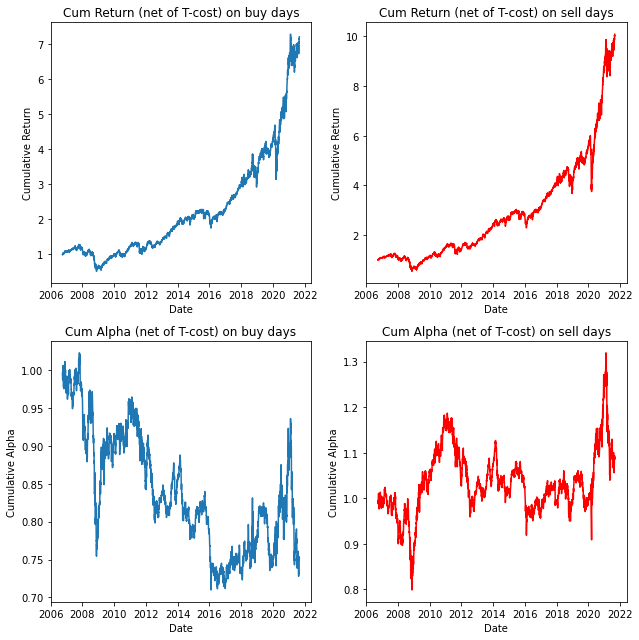

In [38]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     9.121
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           6.25e-10
Time:                        12:19:11   Log-Likelihood:                 10490.
No. Observations:                3760   AIC:                        -2.097e+04
Df Residuals:                    3753   BIC: 

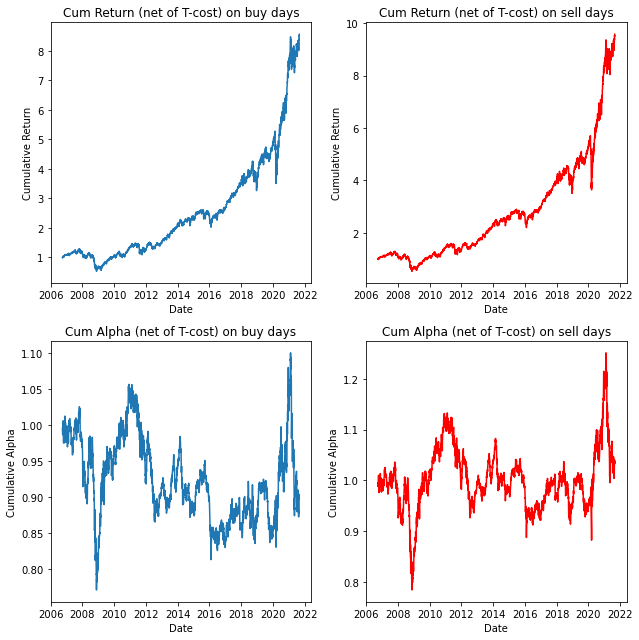

In [39]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     9.282
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           4.01e-10
Time:                        12:19:42   Log-Likelihood:                 10488.
No. Observations:                3760   AIC:                        -2.096e+04
Df Residuals:                    3753   BIC: 

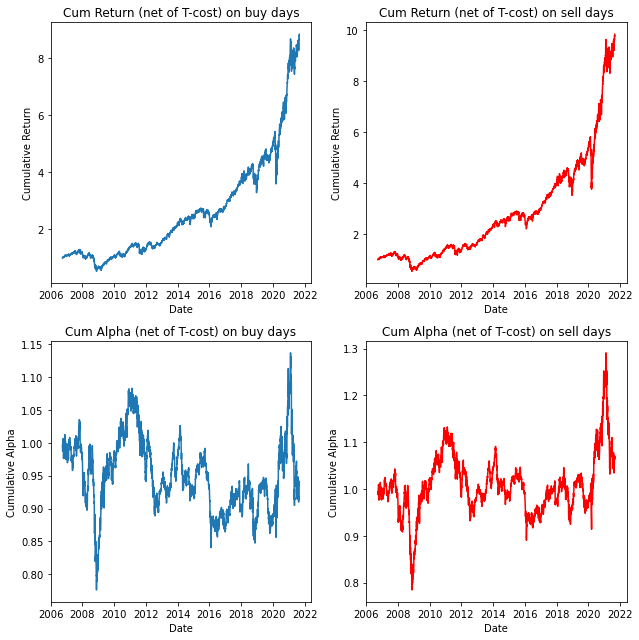

In [40]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)